# Mission Analysis Challenge - ALMENAR Xavier

Code challenge using the Open Space Toolkit (OSTk)

In [99]:
import numpy as np
import pandas as pd
import scipy.optimize as optimize # (pip install scipy if not found)
import plotly.graph_objs as go

from ostk.mathematics.objects import RealInterval

from ostk.physics.units import Length
from ostk.physics.units import Angle
from ostk.physics.time import Scale
from ostk.physics.time import Instant
from ostk.physics.time import Duration
from ostk.physics.time import Interval
from ostk.physics.time import DateTime
from ostk.physics.time import Time
from ostk.physics.coordinate.spherical import LLA
from ostk.physics.coordinate.spherical import AER
from ostk.physics.coordinate import Position
from ostk.physics.coordinate import Frame
from ostk.physics import Environment
from ostk.physics.environment.objects.celestial_bodies import Moon

from ostk.astrodynamics import Trajectory
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.trajectory.orbit.models import Kepler
from ostk.astrodynamics.trajectory.orbit.models.kepler import COE
from ostk.astrodynamics import Access
from ostk.astrodynamics.access import Generator as AccessGenerator

### Initial Orbit setup

First let's check the initial orbit by setting the given parameters and Moon characteristics

In [172]:
environment = Environment.default()
moon = environment.access_celestial_object_with_name("Moon") 

Initial parameters, possible to change:

In [173]:
raan_param = 0.0
true_anomaly = 0.0

Fixed orbital parameters:

In [174]:
a = Moon.equatorial_radius + Length.kilometers(550.0)
e = 0.000
i = Angle.degrees(97.8893)
raan = Angle.degrees(raan_param) # Reminder: subject to change
aop = Angle.degrees(0.0)
nu = Angle.degrees(true_anomaly) # Reminder: subject to change

epoch = Instant.date_time(DateTime(2021, 5, 12, 17, 0, 0), Scale.UTC)

Using a Keplerian model with no perturbation:

In [175]:
coe = COE(a, e, i, raan, aop, nu)
keplerian_model = Kepler(coe, epoch, moon, Kepler.PerturbationType.No)
orbital_model = keplerian_model

satellite_orbit = Orbit(orbital_model, moon)

Initial satellite orbited has been setup

### Access from Rebellion Ground Station

Rebellion Station Coordinates

In [146]:
rebel_lat = Angle.degrees(78.230298)
rebel_lon = Angle.degrees(-75.82381)
rebel_alt = Length.meters(30.0)

In [147]:
from_lla_rebel = LLA(rebel_lat, rebel_lon, rebel_alt)
# Using GCRF because it is the reference for celestial bodies while ITRF uses specific Earth characteristics
from_position_rebel = Position.meters(from_lla_rebel.to_cartesian(Moon.equatorial_radius, Moon.flattening), Frame.GCRF())
from_trajectory_rebel = Trajectory.position(from_position_rebel)

# Start and end datetimes of proximity to the moon
start_instant = Instant.date_time(DateTime(2021, 5, 12, 17, 0, 0), Scale.UTC)
end_instant = Instant.date_time(DateTime(2021, 5, 12, 21, 0, 0), Scale.UTC)

interval = Interval.closed(start_instant, end_instant)


# Rebellion Ground Station: Azimuth-Range-Elevation parameters
azimuth_interval = RealInterval.closed(0.0, 360.0) # [deg]
elevation_interval = RealInterval.closed(0.0, 360.0) # [deg]
range_interval = RealInterval.closed(0.0, 1000e3) # [m]

# Rebel access generator with AER constraints
rebel_access_generator = AccessGenerator.aer_ranges(azimuth_interval, elevation_interval, range_interval, environment)

Computing access from Rebellion Ground Station with initial parameters

In [148]:
rebel_accesses = rebel_access_generator.compute_accesses(interval, from_trajectory_rebel, satellite_orbit)

In [149]:
rebel_accesses_df = pd.DataFrame([[str(access.get_type()), repr(access.get_acquisition_of_signal()), repr(access.get_time_of_closest_approach()), repr(access.get_loss_of_signal()), float(access.get_duration().in_seconds())] for access in rebel_accesses], columns=['Type', 'AOS', 'TCA', 'LOS', 'Duration'])

In [150]:
rebel_accesses_df

,Type,AOS,TCA,LOS,Duration
0,Type.Complete,2021-05-12 17:28:44.881.441.890 [UTC],2021-05-12 17:39:36.937.691.771 [UTC],2021-05-12 17:50:28.994.115.291 [UTC],1304.112673
1,Type.Complete,2021-05-12 20:12:26.468.476.651 [UTC],2021-05-12 20:23:18.524.720.274 [UTC],2021-05-12 20:34:10.581.150.053 [UTC],1304.112673


We can already have a look at the visibility duration during the access:

In [151]:
total_visibility = rebel_accesses_df.Duration.sum()
total_visibility

2608.225346803

So it's already above 2500 seconds as required, now let's verify the laser cannon

### Access from Empire Laser Cannon

Canon coordinates

In [176]:
cannon_lat = Angle.degrees(53.120992)
cannon_lon = Angle.degrees(15.231224)
cannon_alt = Length.meters(30.0)

In [177]:
from_lla_cannon = LLA(cannon_lat, cannon_lon, cannon_alt)
from_position_cannon = Position.meters(from_lla_cannon.to_cartesian(Moon.equatorial_radius, Moon.flattening), Frame.GCRF())
from_trajectory_cannon = Trajectory.position(from_position_cannon)

In [178]:
# Setting up the azimuth elevation mask and range
aer_mask = {0.0:90.0, 45.0:0.0, 135.0:90.0}
cannon_range = RealInterval.closed(0.0, 10000e3) # [m]

# Access generator with Azimuth-Range-Elevation constraints
cannon_access_generator = AccessGenerator.aer_mask(aer_mask, cannon_range, environment)

Computing Cannon acceses with initial orbit conditions

In [179]:
cannon_accesses = cannon_access_generator.compute_accesses(interval, from_trajectory_cannon, satellite_orbit)

In [181]:
if cannon_accesses: # not empty
    cannon_accesses_df = pd.DataFrame([[str(access.get_type()), repr(access.get_acquisition_of_signal()), repr(access.get_time_of_closest_approach()), repr(access.get_loss_of_signal()), float(access.get_duration().in_seconds())] for access in cannon_accesses], columns=['Type', 'AOS', 'TCA', 'LOS', 'Duration'])
    print(cannon_accesses_df)

So there is no visibility from the laser cannon with the initial parameters

### Tuning orbit parameters

As per the visibilities obtained from the rebellion station it looks like during the time near the moon we have time to go complete at least one orbit.

If the Millenium Falcon has enough time to do at least one full orbit, then the initial true anomaly of the orbit shouldn't have an influence on whether the cannon can reach us because it depends to our current position so if we're doing more than one orbit, we would need to be safe from all possible initial true anomaly angles.

Just to double check, let's run a loop with just 6 different initial true anomaly and right ascension of the ascending node. Both parameters by definition they are angles that can range from 0 degrees up to 360.

In [182]:
# Let's setup some arrays to display easily later
raan_param_list, true_ano_list, duration_list = [], [], []

for true_anomaly in np.linspace(0.0, 350.0, num=6):
    for raan_param in np.linspace(0.0, 350.0, num=6):
        # Redifining orbit parameters
        raan = Angle.degrees(raan_param)
        nu = Angle.degrees(true_anomaly)
        
        # Computing orbit, same as initially
        coe = COE(a, e, i, raan, aop, nu)
        keplerian_model = Kepler(coe, epoch, moon, Kepler.PerturbationType.No) 
        orbital_model = keplerian_model
        satellite_orbit = Orbit(orbital_model, moon)
        
        # Recomputing access from Rebellion and Cannon
        rebel_accesses = rebel_access_generator.compute_accesses(interval, from_trajectory_rebel, satellite_orbit)
        cannon_accesses = cannon_access_generator.compute_accesses(interval, from_trajectory_cannon, satellite_orbit)
        
        # At the same time we get a change to do a fast check as well on whether we can avoid the cannon
        if len(cannon_accesses) == 0 and len(rebel_accesses)>0: 
            try:
                # Let's obtain the maximum for every orbit
                rebel_access_duration = max([float(access.get_duration().in_seconds()) for access in rebel_accesses])
            except Exception as exc:
                continue
            else:
                raan_param_list.append(raan_param)
                true_ano_list.append(true_anomaly)
                duration_list.append(rebel_access_duration)
                
            
# Let's just build a dataframe with the results obtained when we're avoiding the cannon
df_impact = pd.DataFrame({'raan':raan_param_list, 'true_anomaly':true_ano_list, 'duration':duration_list})
df_impact

,raan,true_anomaly,duration
0,0.0,0.0,1304.112673
1,140.0,0.0,1059.218729
2,280.0,0.0,1236.423521
3,350.0,0.0,1308.716536
4,0.0,70.0,1304.112673
5,140.0,70.0,1059.218728
6,280.0,70.0,1236.423520
7,350.0,70.0,1308.716536
8,0.0,140.0,1304.112673
9,140.0,140.0,1059.218728


Clearly the initial true anomaly has no impact on duration access for one orbit pass, we can just check correlation being much higher on raan than true anomaly:

In [183]:
df_impact.corr().loc[['raan', 'true_anomaly'], 'duration']

raan            1.409370e-01
true_anomaly    6.481167e-10
Name: duration, dtype: float64

So obviously this makes it easier for optimization, with only 1 tuning parameter. 

We can try using an already built minimization function that allows bracketing such as scipy minimize with the Powell method.

In order to do that we must do a function to calculate the access and return the inverse to the duration so that the algorithm tries to minimise that value and hence increases duration. Also, since the function won't be continuous from 0 to 360, with the table above we can have an idea around where the optimal value must be, somewhere around 350 so we'll bracket it on 200-360.

In [184]:
def recalculate_accesses(raan_param):
    
    raan = Angle.degrees(raan_param[0]) # minimize fonction passes argument as array
    
    # Same orbital calculations as previously
    coe = COE(a, e, i, raan, aop, nu)
    keplerian_model = Kepler(coe, epoch, moon, Kepler.PerturbationType.No)
    orbital_model = keplerian_model
    satellite_orbit = Orbit(orbital_model, moon)
    
    # Compute accesses from both the rebellion and the cannon
    rebel_accesses = rebel_access_generator.compute_accesses(interval, from_trajectory_rebel, satellite_orbit)
    cannon_accesses = cannon_access_generator.compute_accesses(interval, from_trajectory_cannon, satellite_orbit)

    if len(cannon_accesses) == 0:  # we're safe

        rebel_accesses_duration = max([float(access.get_duration().in_seconds()) for access in rebel_accesses])
        return 1/rebel_accesses_duration

    else:
        return 100000.0     # return a high value so that algorithm avoids this area

In [197]:
raan_optimization = optimize.minimize(recalculate_accesses, 350.0, method='Powell', 
                  bounds=optimize.Bounds(lb=np.array([200.0]), ub=np.array([360.0])), options={'maxiter':100})

So the optimal value for the right ascension node should be:

In [198]:
raan_optimal = raan_optimization.x[0]
raan_optimal

325.7340694158056

Once we have raan optimised, we need to find an initial true anomaly that makes the Millenium Falcon go through the access as much as possible. Let's just try with some values:

In [199]:
raan = Angle.degrees(raan_optimal)
raan_param_list, true_ano_list, duration_list = [], [], []

for true_anomaly in np.linspace(0.0, 350.0, num=10):
        
        # Redifining orbit parameters
        nu = Angle.degrees(true_anomaly)
        
        # Computing orbit, same as initially
        coe = COE(a, e, i, raan, aop, nu)
        keplerian_model = Kepler(coe, epoch, moon, Kepler.PerturbationType.No) 
        orbital_model = keplerian_model
        satellite_orbit = Orbit(orbital_model, moon)
        
        # Recomputing access from Rebellion and Cannon
        rebel_accesses = rebel_access_generator.compute_accesses(interval, from_trajectory_rebel, satellite_orbit)
        cannon_accesses = cannon_access_generator.compute_accesses(interval, from_trajectory_cannon, satellite_orbit)
        
        # At the same time we get a change to do a fast check as well on whether we can avoid the cannon
        if len(cannon_accesses) == 0: 
            true_ano_list.append(true_anomaly)

            rebel_access_duration = sum([float(access.get_duration().in_seconds()) for access in rebel_accesses])
            duration_list.append(rebel_access_duration)
            
# Let's just build a dataframe with the results obtained when we're avoiding the cannon
df_impact_true_ano = pd.DataFrame({'true_anomaly':true_ano_list, 'duration':duration_list})
df_impact_true_ano

,true_anomaly,duration
0,0.000000,2635.242986
1,38.888889,2635.242986
2,77.777778,2069.774740
3,116.666667,1317.621493
4,155.555556,1317.621493
5,194.444444,1317.621493
6,233.333333,1317.621493
7,272.222222,1944.785209
8,311.111111,2635.242987
9,350.000000,2635.242987


We see that depending on the true anomaly we'll pass over the rebel access area either once, twice or somewhere in the middle. We can just remain with the initial true anomaly that already provides us maximum visibility.

We can also do a check minimizing both parameters:

In [203]:
def recalculate_accesses_double(args):
    
    raan = Angle.degrees(args[0])
    nu = Angle.degrees(args[1])
    
    # Same orbital calculations as previously
    coe = COE(a, e, i, raan, aop, nu)
    keplerian_model = Kepler(coe, epoch, moon, Kepler.PerturbationType.No)
    orbital_model = keplerian_model
    satellite_orbit = Orbit(orbital_model, moon)
    
    # Compute accesses from both the rebellion and the cannon
    rebel_accesses = rebel_access_generator.compute_accesses(interval, from_trajectory_rebel, satellite_orbit)
    cannon_accesses = cannon_access_generator.compute_accesses(interval, from_trajectory_cannon, satellite_orbit)

    if len(cannon_accesses) == 0:  # we're safe

        rebel_accesses_duration = sum([float(access.get_duration().in_seconds()) for access in rebel_accesses])
        return 1/rebel_accesses_duration

    else:
        return 1000000.0     # return a high value so that algorithm avoids this area

In [204]:
raan_optimization = optimize.minimize(recalculate_accesses_double, [300.0, 0.0], method='Powell', 
                  bounds=optimize.Bounds(lb=np.array([200.0, 0.0]), ub=np.array([360.0, 360.0])), options={'maxiter':100})

In [205]:
raan_optimization.x

array([325.73623189, 322.3883282 ])

We can keep the initial true anomaly:

In [206]:
true_anomaly = 0.0

So with this optimal parameters for the orbit we can recalculate the final orbit and access 
to the Rebellion Ground Station

In [207]:
raan = Angle.degrees(raan_optimization.x[0]) # attention, using optimal raan

nu = Angle.degrees(raan_optimization.x[1])
coe = COE(a, e, i, raan, aop, nu)
keplerian_model = Kepler(coe, epoch, moon, Kepler.PerturbationType.No)
orbital_model = keplerian_model
satellite_orbit = Orbit(orbital_model, moon)

rebel_accesses = rebel_access_generator.compute_accesses(interval, from_trajectory_rebel, satellite_orbit)
cannon_accesses = cannon_access_generator.compute_accesses(interval, from_trajectory_cannon, satellite_orbit)

In [208]:
rebel_accesses_df = pd.DataFrame([[str(access.get_type()), repr(access.get_acquisition_of_signal()), repr(access.get_time_of_closest_approach()), repr(access.get_loss_of_signal()), 
                                   float(access.get_duration().in_seconds())] for access in rebel_accesses], columns=['Type', 'AOS', 'TCA', 'LOS', 'Duration'])
rebel_accesses_df

,Type,AOS,TCA,LOS,Duration
0,Type.Complete,2021-05-12 17:43:02.616.301.772 [UTC],2021-05-12 17:54:01.427.138.248 [UTC],2021-05-12 18:05:00.237.795.709 [UTC],1317.621494
1,Type.Complete,2021-05-12 20:26:44.203.337.429 [UTC],2021-05-12 20:37:43.014.046.751 [UTC],2021-05-12 20:48:41.824.830.471 [UTC],1317.621493


In [209]:
total_visibility = rebel_accesses_df.Duration.sum()

In [210]:
total_visibility

2635.2429869790003

In [216]:
cannon_accesses

[]

Verified total visibility > 2500 seconds and no visibility from laser cannon

### Plot Orbit, Access area, Station and Cannon

In [211]:
def compute_lla(state):
    
    lla = LLA.cartesian(state.get_position().in_frame(Frame.GCRF(), state.get_instant()).get_coordinates(), Moon.equatorial_radius, Moon.flattening)

    return [float(lla.get_latitude().in_degrees()), float(lla.get_longitude().in_degrees()), float(lla.get_altitude().in_meters())]

def compute_aer(instant, from_lla, to_position):
    
    nedFrame = moon.get_frame_at(from_lla, Moon.FrameType.NED)
    
    from_position = Position.meters(from_lla.to_cartesian(Moon.equatorial_radius, Moon.flattening), Frame.GCRF())
    
    fromPosition_NED = from_position.in_frame(nedFrame, instant)
    sunPosition_NED = to_position.in_frame(nedFrame, instant)

    aer = AER.from_position_to_position(fromPosition_NED, sunPosition_NED, True)
            
    return [float(aer.get_azimuth().in_degrees()), float(aer.get_elevation().in_degrees()), float(aer.get_range().in_meters())]

def compute_time_lla_aer_state(state):
    
    instant = state.get_instant()
    
    lla = compute_lla(state)
    aer = compute_aer(instant, from_lla_rebel, state.get_position().in_frame(Frame.ITRF(), state.get_instant()))

    return [instant, lla[0], lla[1], lla[2], aer[0], aer[1], aer[2]]

def compute_trajectory_geometry(aTrajectory, anInterval):

    return [compute_lla(state) for state in aTrajectory.get_states_at(anInterval.generate_grid(Duration.minutes(1.0)))]

def compute_access_geometry(access):

    return [compute_time_lla_aer_state(state) for state in satellite_orbit.get_states_at(access.get_interval().generate_grid(Duration.seconds(1.0)))]

In [212]:
satellite_orbit_geometry_df = pd.DataFrame(compute_trajectory_geometry(satellite_orbit, interval), columns=['Latitude', 'Longitude', 'Altitude'])

In [213]:
satellite_orbit_geometry_df.head()

,Latitude,Longitude,Altitude
0,-37.247449,-28.227252,550794.660376
1,-35.078945,-28.689915,550716.389907
2,-32.908481,-29.128659,550640.175521
3,-30.736274,-29.546443,550566.466763
4,-28.562512,-29.945842,550495.698512


In [214]:
access_geometry_dfs = [pd.DataFrame(compute_access_geometry(access), columns=['Time', 'Latitude', 'Longitude', 'Altitude', 'Azimuth', 'Elevation', 'Range']) for access in rebel_accesses] ;

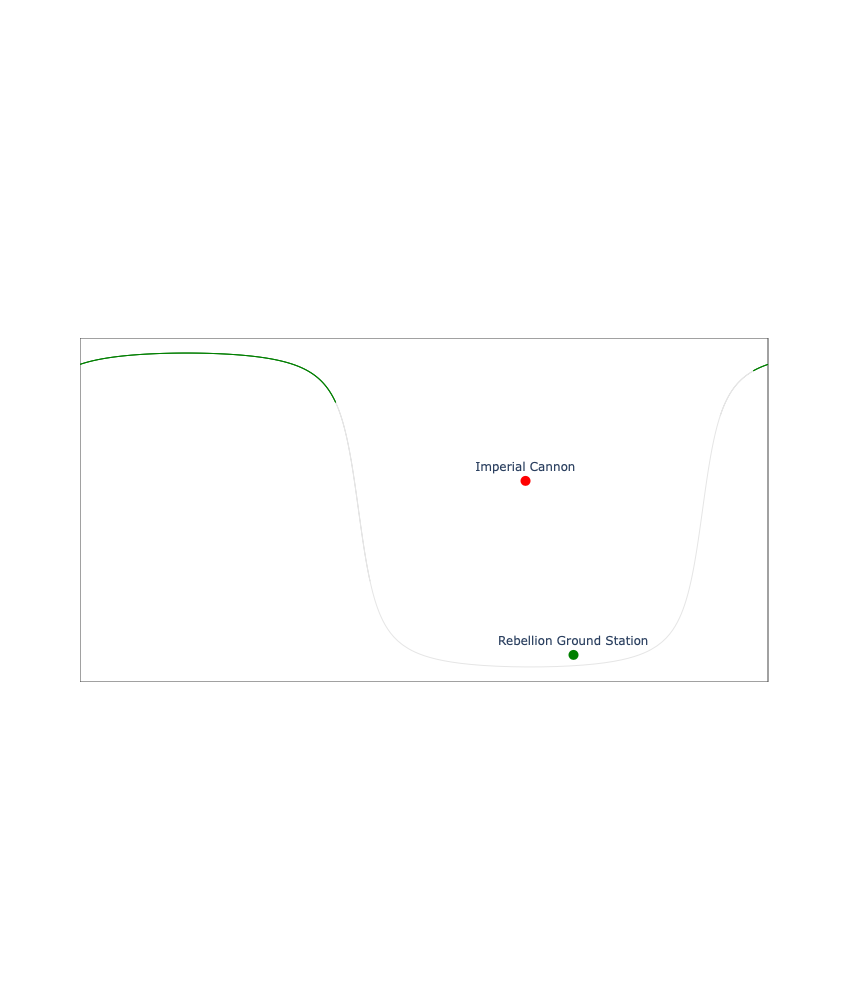

In [219]:
data = []

# Rebellion marker

data.append(
    dict(
        type = 'scattergeo',
        lon = [float(rebel_lat.in_degrees())],
        lat = [float(rebel_lon.in_degrees())],
        mode = 'markers+text',
        marker = dict(
            size = 10,
            color = 'green'
        ),
        text = 'Rebellion Ground Station',
        textposition = 'top center'
    )
)

# Laser cannon marker 

data.append(
    dict(
        type = 'scattergeo',
        lon = [float(cannon_lat.in_degrees())],
        lat = [float(cannon_lon.in_degrees())],
        mode = 'markers+text',
        marker = dict(
            size = 10,
            color = 'red'
        ),
        text = 'Imperial Cannon',
        textposition = 'top center'
    )
)

# Orbit geometry

data.append(
    dict(
        type = 'scattergeo',
        lon = satellite_orbit_geometry_df['Longitude'],
        lat = satellite_orbit_geometry_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 1,
            color = 'rgba(0, 0, 0, 0.1)',
        )
    )
)

# Access geometry

for access_geometry_df in access_geometry_dfs:
    
    data.append(
        dict(
            type = 'scattergeo',
            lon = access_geometry_df['Longitude'],
            lat = access_geometry_df['Latitude'],
            mode = 'lines',
            line = dict(
                width = 1,
                color = 'green',
            )
        )
    )
    
layout = dict(
        title = None,
        showlegend = False,
        height = 1000,
        geo = go.layout.Geo(
            showcoastlines=False,
            showland = False
        )
        
    )
    
figure = go.Figure(data = data, layout = layout)

figure.show()